<b>Data mining project - 2020/21</b><br>
<b>Authors</b>: [Alexandra Bradan](https://github.com/alexandrabradan), [Alice Graziani](https://github.com/alicegraziani25) and [Eleonora Cocciu](https://github.com/eleonoracocciu)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 21/05/2021<b>

In [92]:
# system library
import os
import sys
import json
import pickle
import isoweek
import datetime
import calendar
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta

# useful libraries
import math
import operator
import itertools
import statistics
import collections
from collections import Counter
from collections import OrderedDict

# pandas
import pandas as pd

# numpy
import numpy as np
from numpy import std
from numpy import mean
from numpy import percentile

# visualisarion
import pydotplus
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import Image

# sklearn
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# dimensional reducers
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif  # classification
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression  # regression

# scalers
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder

# performance visualisation 
from sklearn import tree
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.model_selection import learning_curve
from mlxtend.plotting import plot_decision_regions
from yellowbrick.model_selection import LearningCurve

# tree classifiers
from sklearn.tree import DecisionTreeClassifier

# neighbors classifiers
from sklearn.neighbors import KNeighborsClassifier

# regression
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline

from yellowbrick.style import set_palette
set_palette('bold')

In [62]:
ts_column_name = 'frequency'

<h6> Datasets loading </h6>

In [63]:
filename = "TS_album_type_" + ts_column_name + ".csv"
df = pd.read_csv('../../data/fma_metadata/' + filename, index_col=0)
print(df.shape)

# converting the index as date
df.index = pd.to_datetime(df.index)

(70224, 3)


<h6>Plot functions </h6>

In [64]:
cmap = plt.cm.cool
color = "cyan"

In [65]:
# PLOT FUNCTIONS
def plot_roc_curve(y_ts, y_prob, model_name, g):
    plt.figure(figsize=(8, 5))
    plot_roc(y_ts, y_prob)
    plt.title("%s %s granularity\'s ROC curve" % (model_name, g))
    plt.show()
    
    
def plot_my_lift_curve(y_ts, y_prob, model_name, g):
    plt.figure(figsize=(8, 5))
    plot_lift_curve(y_ts, y_prob)
    plt.title("%s %s granularity\'s Lift curve" % (model_name, g))
    plt.show()
    
def plot_confusion_matrix(cm, classes, normalize, model_name, g):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("%s %s granularity\'s classification report" % (model_name, g))
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_classification_report(y_ts, y_pred, model_name, g):
    model_report = classification_report(y_ts, 
                                       y_pred,
                                       # target_names=['Studio Recording', 'Live Recording'],
                                       output_dict=True)
    model_r = pd.DataFrame(model_report).iloc[:-1, :].T
    sns.heatmap(model_r, annot=True, cmap=cmap, cbar=False)
    plt.title("%s %s granularity\'s confusion matrix" % (model_name, g))
    plt.show()

<h6>Clustering datasets construction </h6>

In [66]:
# retrieve Studio and Live DataFrames
studio_key = 'Studio_Recording_' + ts_column_name
live_key = 'Live_Recording_' + ts_column_name

global_studio_ts = df[studio_key]
global_live_ts = df[live_key]

# converting the index as date
global_studio_ts.index = pd.to_datetime(global_studio_ts.index)
global_live_ts.index = pd.to_datetime(global_live_ts.index)

# drop 2008 and 2017
to_drop = global_studio_ts[(global_studio_ts.index.year == 2008) | (global_studio_ts.index.year == 2017)].index
global_studio_ts.drop(to_drop, axis=0, inplace=True)
to_drop = global_live_ts[(global_live_ts.index.year == 2008) | (global_live_ts.index.year == 2017)].index
global_live_ts.drop(to_drop, axis=0, inplace=True)

# channging datetime index frequency
studio_list_of_dataframes = {}
live_list_of_dataframes = {}
granularities = ['Y', 'M', 'W', 'D', 'H']

for g in granularities:
    # converting the index as date
    tmp_studio_ts = global_studio_ts.copy()
    studio_list_of_dataframes[g] = tmp_studio_ts.resample(g).mean().to_frame()
    
    tmp_live_ts = global_live_ts.copy()
    live_list_of_dataframes[g] = tmp_live_ts.resample(g).mean().to_frame()
    
for key, value in studio_list_of_dataframes.items():
    print("granularity=%s" % key, "shape=%s" % value.shape[0], sep='\t')

granularity=Y	shape=8
granularity=M	shape=96
granularity=W	shape=418
granularity=D	shape=2922
granularity=H	shape=70128


In [67]:
def hour_of_year(dt): 
    beginning_of_year = datetime.datetime(dt.year, 1, 1, tzinfo=dt.tzinfo)
    return (dt - beginning_of_year).total_seconds() // 3600

In [68]:
def get_clustering_datasets(list_of_dataframes, name):

    clustering_list_of_dataframes = {} 
    years = list(range(2009, 2017))
    for g in granularities:

        data = {'track_date_created_year': years}

        if g == 'Y':
            unique_values = 1
        elif g == 'M':
            unique_values = 12
        elif g == 'W':
            unique_values = 52
        elif g == 'D':
            unique_values = 365
        elif g == 'H':
            unique_values = 8760

        rows_and_columns = {}
        for year in years:
            rows_and_columns[year] = [0]*unique_values

        for idx, value in zip(list_of_dataframes[g].index, list_of_dataframes[g].values):
            y = idx.year
            m = idx.month
            w = idx.week
            d = idx.timetuple().tm_yday  # day of year
            h = hour_of_year(idx)
            
            if y == 2017:
                y = 2016
                m = 12
                d = 31

            if w > 52:
                w = 52
                
            if d > 365:
                d = 365

            if h > 8760:
                h = 8760
                

            if g == 'Y':
                key = 0
            elif g == 'M':
                key = m-1
            elif g == 'W':
                key = w-1
            elif g == 'D':
                key = d-1
            elif g == 'H':
                key = int(h-1)

            rows_and_columns[y][key] += value[0]
            
        global_key = '%s_' % name + g 
        for j in range(0, unique_values):
            key = global_key
            if g != 'Y':
                key = key + "_" + str(j)
            recreated_column = []
            for year in years: 
                value = rows_and_columns[year][j] 
                recreated_column.append(value)
            data[key] = recreated_column   

        # create dataset
        df_ts = pd.DataFrame(data=data, columns=list(data.keys()))
        df_ts = df_ts.set_index('track_date_created_year')
        clustering_list_of_dataframes[g] = df_ts
        
    return clustering_list_of_dataframes

In [69]:
def get_merged_clustering_datasets(clustering_studio_list_of_dataframes, 
                                                                clustering_live_list_of_dataframes):
    clustering_list_of_dataframes = {}
    years = list(range(2009, 2017))
    for g in granularities:
        ts1 = clustering_studio_list_of_dataframes[g].copy()
        ts2 = clustering_live_list_of_dataframes[g].copy()

        new_indeces = []
        new_indeces += [str(idx) + "_" + studio_key.replace("_%s" % ts_column_name, "") for idx in ts1.index]
        new_indeces += [str(idx) + "_" + live_key.replace("_%s" % ts_column_name, "") for idx in ts2.index]
        data = {'track_date_created_year': new_indeces}

        if g == 'Y':
            unique_values = 1
        elif g == 'M':
            unique_values = 12
        elif g == 'W':
            unique_values = 52
        elif g == 'D':
            unique_values = 365
        elif g == 'H':
            unique_values = 8760

        global_key1 = '%s_' % studio_key + g 
        global_key2 = '%s_' % live_key + g 
        for j in range(0, unique_values):
            key1 = global_key1
            key2 = global_key2
            if g != 'Y':
                key1 = key1 + "_" + str(j)
                key2 = key2 + "_" + str(j)

            colum1 = list(ts1[key1].values)
            colum2 = list(ts2[key2].values)

            # merge columns
            colum1 += colum2

            key = 'Merged_Recording_%s_' % ts_column_name  + g + "_" + str(j)
            data[key] = colum1   

        # create dataset
        df_ts = pd.DataFrame(data=data, columns=list(data.keys()))
        df_ts = df_ts.set_index('track_date_created_year')
        clustering_list_of_dataframes[g] = df_ts

    return clustering_list_of_dataframes

In [70]:
clustering_studio_list_of_dataframes = get_clustering_datasets(studio_list_of_dataframes, studio_key)

In [71]:
clustering_live_list_of_dataframes = get_clustering_datasets(live_list_of_dataframes, live_key)

In [72]:
clustering_merged_list_of_dataframes = get_merged_clustering_datasets(clustering_studio_list_of_dataframes, 
                                                                    clustering_live_list_of_dataframes)

In [73]:
# studio DataFrame isnight (analogous for live)
for g in granularities:
    print(g, clustering_studio_list_of_dataframes[g].shape)

Y (8, 1)
M (8, 12)
W (8, 52)
D (8, 365)
H (8, 8760)


In [74]:
# merged DataFrame insight
for g in granularities:
    print(g, clustering_merged_list_of_dataframes[g].shape)

Y (16, 1)
M (16, 12)
W (16, 52)
D (16, 365)
H (16, 8760)


<h6> Datasets visualisation </h6>

In [75]:
def get_x_and_y(external_df, g):
    x = list(external_df.columns)
    x = [int(elem.split("_Recording_%s_%s_" % (ts_column_name, g))[1]) for elem in x]
    y = []
    for i in range(0, external_df.shape[0]):
        y.append([])
        for j in range(0, external_df.shape[1]):
            y[i].append(external_df.iloc[i, j])
    return x, y

In [76]:
def print_datasets(clustering_list_of_dataframes, name):
    years = list(range(2009, 2017))
    colors = ['red', 'green', 'blue', 'purple', 'brown', 'black', 'orange', 'yellow']
    for g in granularities:
        if g == 'Y':
            continue
        x, y = get_x_and_y(clustering_list_of_dataframes[g], g)
        fig, ax = plt.subplots(figsize=(8, 5))
        for i in range(0, len(y)):
            plt.plot(x, y[i], label=str(years[i]), color=colors[i])
        plt.xlabel(g)
        plt.ylabel(ts_column_name)
        plt.legend(title="years:", loc="best", ncol=3)
        plt.title("%s's %s granularity datasets" % (name, g))
        plt.show()

In [77]:
def print_merged_datasets(clustering_list_of_dataframes, name):
    years = list(range(2009, 2017))
    colors = ['red', 'green', 'blue', 'purple', 'brown', 'black', 'orange', 'yellow']
    for g in granularities:
        if g == 'Y':
            continue
        x, y = get_x_and_y(clustering_list_of_dataframes[g], g)
        x, y = get_x_and_y(clustering_list_of_dataframes[g], g)
        fig, ax = plt.subplots(figsize=(8, 5))
        for i in range(0, len(y)):
            plt.plot(x, y[i], label=str(years[i]), color=colors[i])
        plt.xlabel(g)
        plt.ylabel(ts_column_name)
        plt.legend(title="years:", loc="best", ncol=3)
        plt.title("%s's %s granularity datasets" % (name, g))
        plt.show()

In [78]:
# print_datasets(clustering_studio_list_of_dataframes, studio_key)

In [79]:
# print_datasets(clustering_live_list_of_dataframes, live_key)

In [80]:
# print_datasets(clustering_merged_list_of_dataframes, "Merged_Recording_%s" % ts_column_name)

<h2> ShapletClassifier </h2>

In [81]:
import tensorflow as tf
from keras.optimizers import Adagrad
from tslearn.shapelets import ShapeletModel
from tslearn.shapelets import LearningShapelets
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

from tslearn.utils import ts_size
from tslearn.utils import to_time_series_dataset

from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

In [82]:
shp_standars_classifiers = {}

In [83]:
def shapelet_model_classification(g, n_shapelets_per_size):
    
    model_name = "ShapeletModel"
    if g == 'Y': 
        return

    # define indipendend and dipendent variables
    X, y = to_time_series_dataset(clustering_merged_list_of_dataframes[g].values), np.array(([0]*8 + [1]*8))
    
    # 70-30 holdout
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
    
    # NORMALIZATION
    scaler = TimeSeriesScalerMinMax()
    X_train = scaler.fit_transform(X_train).reshape(X_train.shape[0], X_train.shape[1])
    X_test = scaler.transform(X_test).reshape(X_test.shape[0], X_test.shape[1])
    
    n_ts, ts_sz = X_train.shape[:2]
    n_classes = len(set(y))

    # Set the number of shapelets per size as done in the original paper
    if n_shapelets_per_size == -1:
        n_shapelets_per_size = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                               ts_sz=ts_sz,
                                                               n_classes=n_classes,
                                                               l=0.1,
                                                               r=1)

    print('n_ts', n_ts)
    print('ts_sz', ts_sz)
    print('n_classes', n_classes)
    print('shapelet_sizes', n_shapelets_per_size)
    
    
    # Define the model using parameters provided by the authors (except that we use
    # fewer iterations here)
    shp_clf = ShapeletModel(n_shapelets_per_size=n_shapelets_per_size,
                            optimizer="sgd",
                            weight_regularizer=.01,
                            max_iter=200,
                            verbose=0,
                            random_state=42)
    # fit the model
    shp_clf.fit(X_train, y_train)
    
    # predict
    y_pred = shp_clf.predict(X_test)
    
    # predict probabilities
    y_prob = shp_clf.predict_proba(X_test)
    
    # plots
    cm = confusion_matrix(y_test, y_pred)
    plot_classification_report(y_test, y_pred, model_name, g)
    plot_confusion_matrix(cm, [0, 1], True, model_name, g)
    plot_roc_curve(y_test, y_prob, model_name, g)
    plot_my_lift_curve(y_test, y_prob, model_name, g)
    
    # saving ShapletClassifier
    shp_standars_classifiers[g] = shp_clf
    
    print()
    print("-----------------------------------------------------------------------------------------------------")
    print()

n_ts 14
ts_sz 12
n_classes 2
shapelet_sizes {1: 2}


/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.

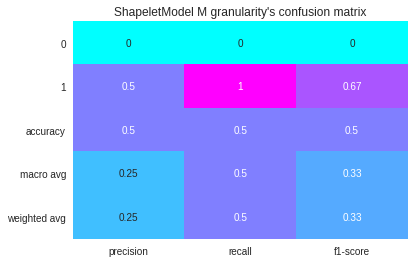

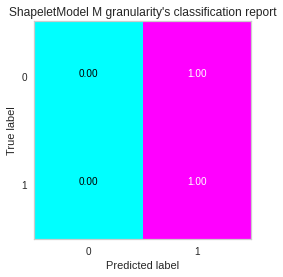

<Figure size 576x360 with 0 Axes>

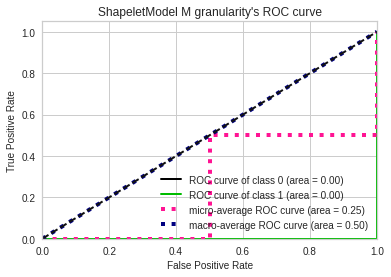

<Figure size 576x360 with 0 Axes>

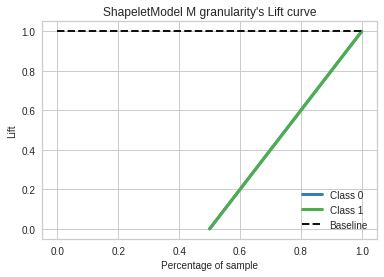


-----------------------------------------------------------------------------------------------------



In [84]:
shapelet_model_classification('M', n_shapelets_per_size=-1)

n_ts 14
ts_sz 52
n_classes 2
shapelet_sizes {5: 2}


/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.

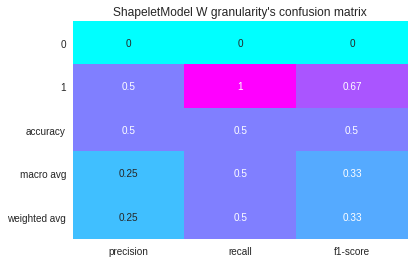

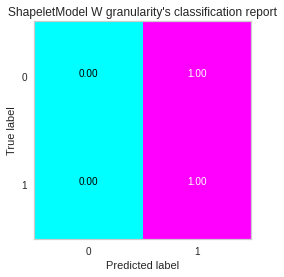

<Figure size 576x360 with 0 Axes>

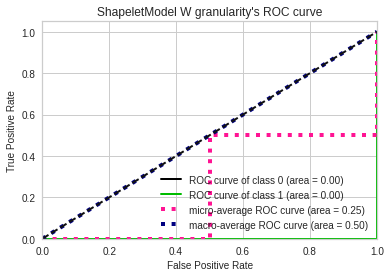

<Figure size 576x360 with 0 Axes>

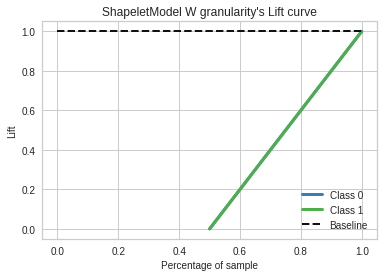


-----------------------------------------------------------------------------------------------------



In [85]:
shapelet_model_classification('W', n_shapelets_per_size=-1)

n_ts 14
ts_sz 365
n_classes 2
shapelet_sizes {36: 3}


/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.

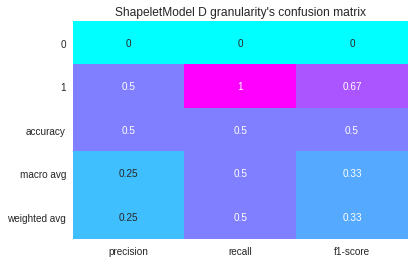

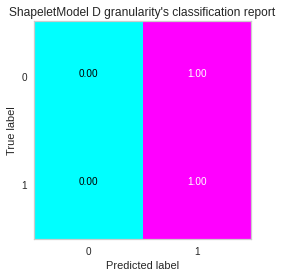

<Figure size 576x360 with 0 Axes>

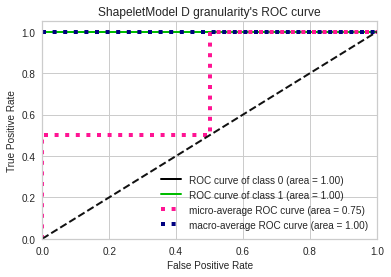

<Figure size 576x360 with 0 Axes>

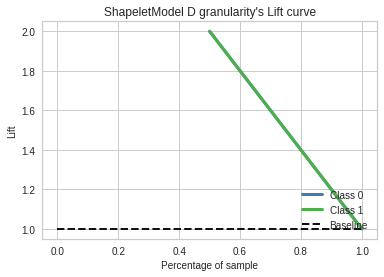


-----------------------------------------------------------------------------------------------------



In [86]:
shapelet_model_classification('D', n_shapelets_per_size=-1)

In [87]:
# shapelet_model_classification('H', n_shapelets_per_size=-1)

<h2> Shaplet-distances-based Classifier </h2>

In [88]:
def knn_grid(X_tr):
    grid = dict()
    sqrt_records = round(math.sqrt(X_tr.shape[0]))
    grid['model__n_neighbors'] = list(range(3, sqrt_records*2, 2))
    grid['model__p'] = [1, 2]
    grid['model__weights'] = ['uniform', 'distance']
    return grid

In [89]:
def dt_grid(X_tr):
    grid = dict()
    grid['model__criterion'] = ['gini', 'entropy']
    grid['model__max_features'] = [None, 'auto', 'sqrt', 'log2']
    grid['model__max_depth'] = [None] + list(np.arange(1, X_tr.shape[1] + 1))
    grid['model__min_samples_split'] = list(range(1, X_tr.shape[0] + 1))
    grid['model__min_samples_leaf'] = list(range(1, X_tr.shape[0] + 1))
    grid['model__class_weight'] = ['balanced', None]
    return grid

In [109]:
def grid_search(X_tr, X_ts, y_tr, y_ts, grid, model, model_name, g, turn_off_grid_flag):
    
    search = None
    if turn_off_grid_flag:  # not performing the grid-search, but using standard model
        search = model
    else:
        # define the evaluation method
        cv = StratifiedKFold(n_splits=3)

        # construct the pipeline to evaluate
        steps = [('model', model)]

        # define the pipeline to evaluate
        pipeline = Pipeline(steps=steps)

        # define the grid search
        # search = GridSearchCV(pipeline, grid, scoring='f1_weighted', n_jobs=-1, cv=cv, verbose=2)
        search = RandomizedSearchCV(pipeline, grid, scoring='f1_weighted', n_jobs=-1, 
                                    n_iter=200, cv=3, verbose=2, refit='f1_weighted', random_state=42)

    # perform the search
    results = search.fit(X_tr, y_tr)
    
    if turn_off_grid_flag == False:
        # summarize best
        params = results.best_params_
        print('Best Config: %s ' % params)
    
    # perform classification
    y_pred = search.predict(X_ts)
    y_prob = search.predict_proba(X_ts)
    
    # plots
    cm = confusion_matrix(y_ts, y_pred)
    plot_confusion_matrix(cm, results.classes_, True, model_name, g)
    plot_classification_report(y_ts, y_pred, model_name, g)
    plot_roc_curve(y_ts, y_prob, model_name, g)
    plot_my_lift_curve(y_ts, y_prob, model_name, g)
    
    
    if 'DT' in model_name and "Shaplet-distances-based Classifier" not in model_name:
        importances = search.feature_importances_
        indices = np.argsort(importances)
        
        fig, ax = plt.subplots(figsize=(8, 5))
        plt.title('Feature Importances')
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
        
        plt.show()


In [110]:
g = 'M'

# define indipendend and dipendent variables
X, y = clustering_merged_list_of_dataframes[g].values, np.array(([0]*8 + [1]*8))

# NORMALIZATION
scaler = TimeSeriesScalerMinMax()
X = scaler.fit_transform(X).reshape(X.shape[0], X.shape[1])

# 70-30 holdout
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

shp_clf = shp_standars_classifiers[g]

X_train2 = shp_clf.transform(X_train)
X_test2 = shp_clf.transform(X_test)

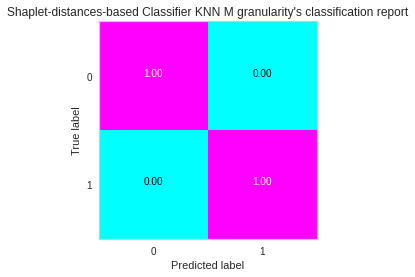

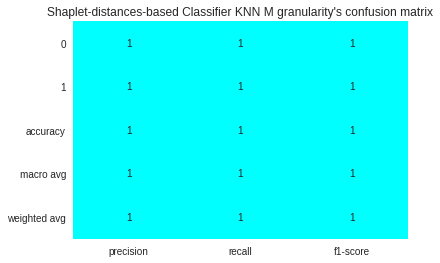

<Figure size 576x360 with 0 Axes>

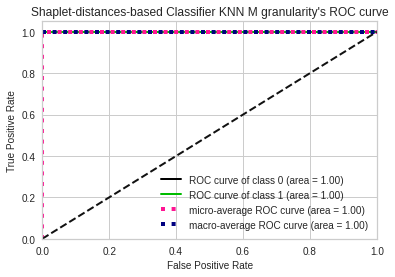

<Figure size 576x360 with 0 Axes>

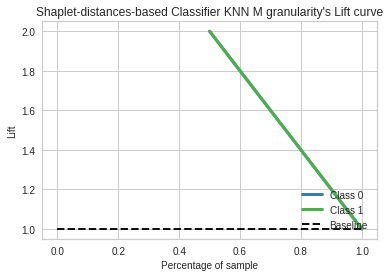

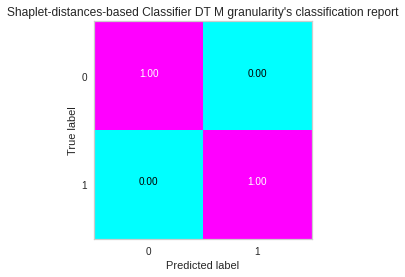

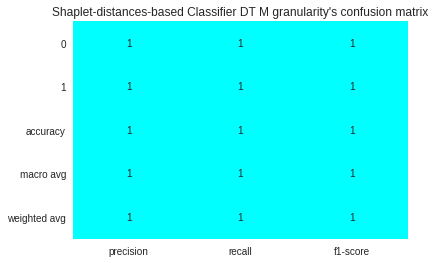

<Figure size 576x360 with 0 Axes>

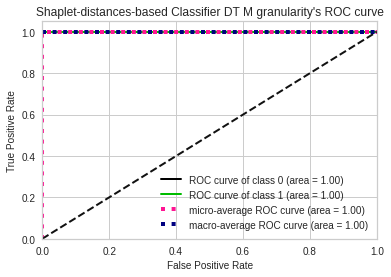

<Figure size 576x360 with 0 Axes>

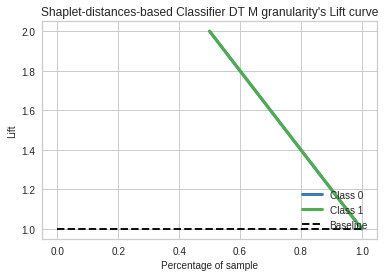


-----------------------------------------------------------------------------------------------------



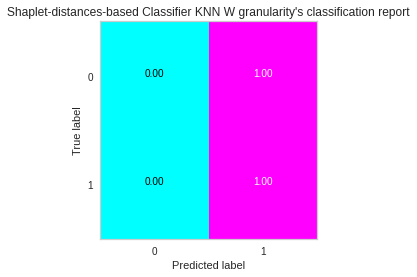

/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


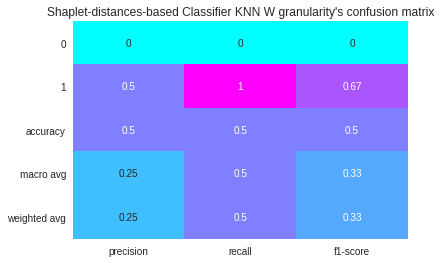

<Figure size 576x360 with 0 Axes>

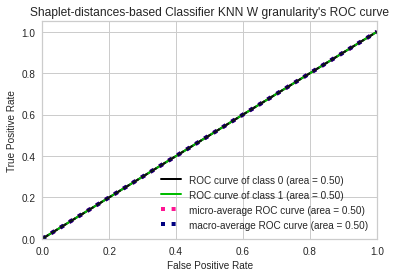

<Figure size 576x360 with 0 Axes>

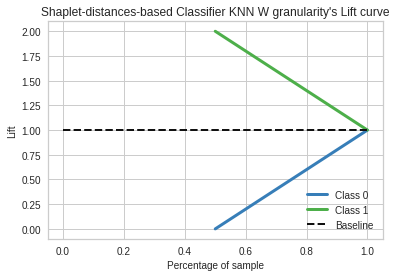

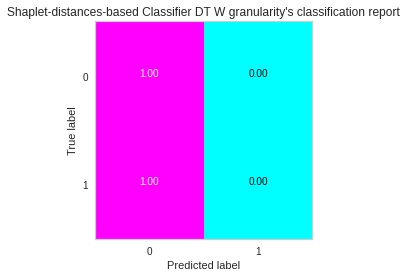

/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


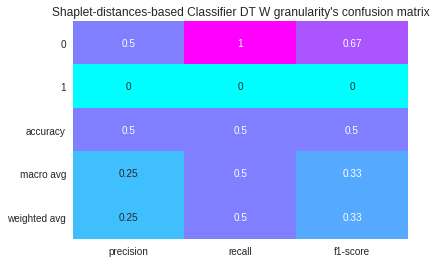

<Figure size 576x360 with 0 Axes>

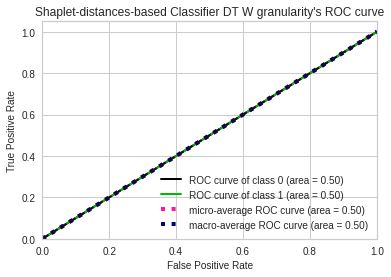

<Figure size 576x360 with 0 Axes>

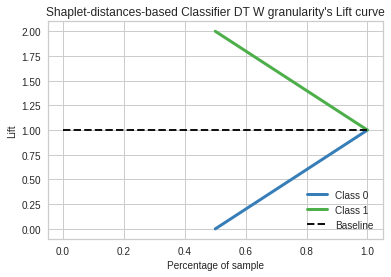


-----------------------------------------------------------------------------------------------------



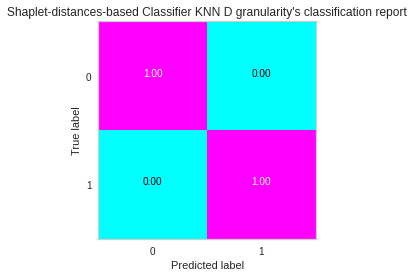

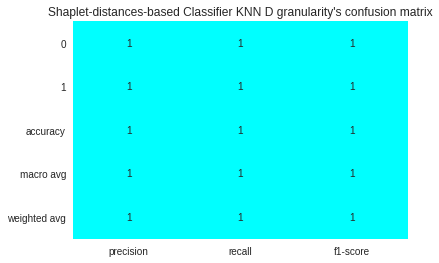

<Figure size 576x360 with 0 Axes>

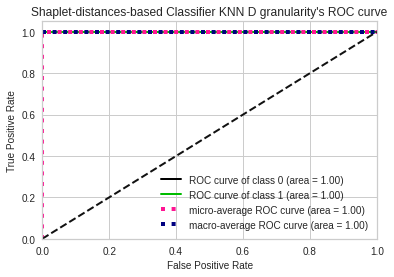

<Figure size 576x360 with 0 Axes>

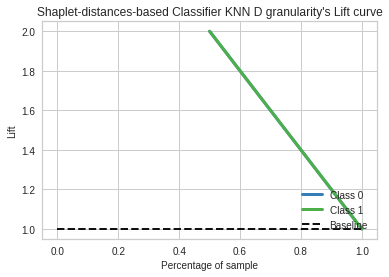

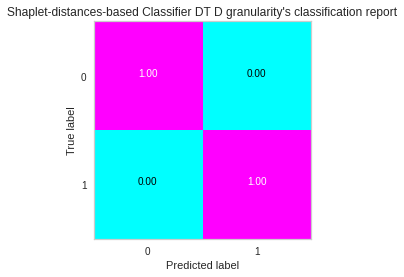

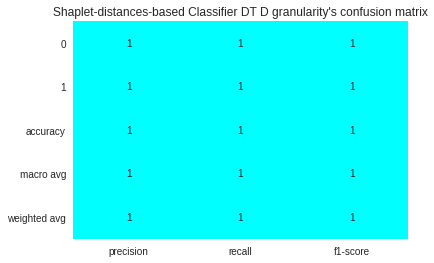

<Figure size 576x360 with 0 Axes>

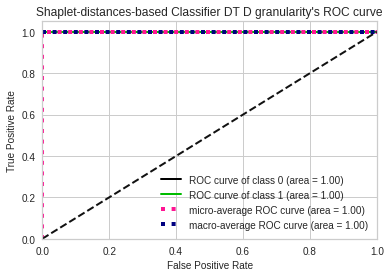

<Figure size 576x360 with 0 Axes>

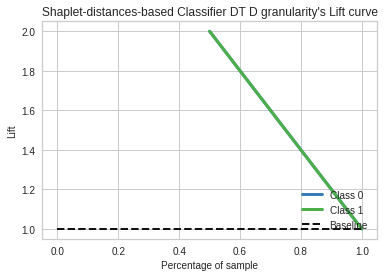


-----------------------------------------------------------------------------------------------------



In [111]:
model_name = "Shaplet-distances-based Classifier"
turn_off_grid_flag = True
for g in granularities:
    if g == 'Y' or g == 'H': 
        continue
        
    # define indipendend and dipendent variables
    X, y = clustering_merged_list_of_dataframes[g].values, np.array(([0]*8 + [1]*8))
    
    # NORMALIZATION
    scaler = TimeSeriesScalerMinMax()
    X = scaler.fit_transform(X).reshape(X.shape[0], X.shape[1])
    
    # 70-30 holdout
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
        
    shp_clf = shp_standars_classifiers[g]
    
    X_train2 = shp_clf.transform(X_train)
    X_test2 = shp_clf.transform(X_test)
    
    # DecisionTreeClassifier
    grid = knn_grid(X_train2)
    model = KNeighborsClassifier(n_jobs=-1)
    grid_search(X_train2, X_test2, y_train, y_test, grid, model, model_name + " KNN", g, turn_off_grid_flag)
    
    # KNeighborsClassifier
    grid = dt_grid(X_train2)
    model = DecisionTreeClassifier(random_state=42)
    grid_search(X_train2, X_test2, y_train, y_test, grid, model, model_name + " DT", g, turn_off_grid_flag)
    
    print()
    print("-----------------------------------------------------------------------------------------------------")
    print()

<h2> Feature-based Classifier </h2>

In [112]:
import scipy.stats as stats

In [113]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [ ]:
model_name = "Feature-base"
turn_off_grid_flag = True
for g in granularities:
    if g == 'Y': 
        continue
        
    # define indipendend and dipendent variables
    X, y = clustering_merged_list_of_dataframes[g].values, np.array(([0]*8 + [1]*8))
    
    # NORMALIZATION
    scaler = TimeSeriesScalerMinMax()
    X = scaler.fit_transform(X).reshape(X.shape[0], X.shape[1])
    
    # 70-30 holdout
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
        
    X_train3 = np.array([list(calculate_features(x).values()) for x in X_train])
    X_test3 = np.array([list(calculate_features(x).values()) for x in X_test])
    
    # DecisionTreeClassifier
    grid = knn_grid(X_train3)
    model = KNeighborsClassifier(n_jobs=-1)
    grid_search(X_train3, X_test3, y_train, y_test, grid, model, model_name + " KNN", g, turn_off_grid_flag)
    
    # KNeighborsClassifier
    grid = dt_grid(X_train3)
    model = DecisionTreeClassifier(random_state=42)
    grid_search(X_train3, X_test3, y_train, y_test, grid, model, model_name + " DT", g, turn_off_grid_flag)
    
    print()
    print("-----------------------------------------------------------------------------------------------------")
    print()

In [ ]:
model_name = "Shaplet-distances-based Classifier"
turn_off_grid_flag = False
for g in granularities:
    if g == 'Y': 
        continue
        
    # define indipendend and dipendent variables
    X, y = clustering_merged_list_of_dataframes[g].values, np.array(([0]*8 + [1]*8))
    
    # NORMALIZATION
    scaler = TimeSeriesScalerMinMax()
    X = scaler.fit_transform(X).reshape(X.shape[0], X.shape[1])
    
    # 70-30 holdout
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
        
    X_train3 = np.array([list(calculate_features(x).values()) for x in X_train])
    X_test3 = np.array([list(calculate_features(x).values()) for x in X_test])
    
    # DecisionTreeClassifier
    grid = knn_grid(X_train3)
    model = KNeighborsClassifier(n_jobs=-1)
    grid_search(X_train3, X_test3, y_train, y_test, grid, model, model_name + " KNN", g, turn_off_grid_flag)
    
    # KNeighborsClassifier
    grid = dt_grid(X_train3)
    model = DecisionTreeClassifier(random_state=42)
    grid_search(X_train3, X_test3, y_train, y_test, grid, model, model_name + " DT", g, turn_off_grid_flag)
    
    print()
    print("-----------------------------------------------------------------------------------------------------")
    print()

<h2>Time Series Classifier</h2>


We detected that KNN and DT doesn't perform well solely uppon plain TSs datasets.

turn_off_grid_flag = True
for g in granularities:
     if g == 'Y': 
        continue
        
    # define indipendend and dipendent variables
    X, y = clustering_merged_list_of_dataframes[g].values, np.array(([0]*8 + [1]*8))
    
    # NORMALIZATION
    scaler = TimeSeriesScalerMinMax()
    X = scaler.fit_transform(X).reshape(X.shape[0], X.shape[1])
    
    # 70-30 holdout
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
    
    # DecisionTreeClassifier
    grid = knn_grid(X_train)
    model = KNeighborsClassifier(n_jobs=-1)
    grid_search(X_train, X_test, y_train, y_test, grid, model, "KNN", g, turn_off_grid_flag)
    
    # KNeighborsClassifier
    grid = dt_grid(X_train)
    model = DecisionTreeClassifier(random_state=42)
    grid_search(X_train, X_test, y_train, y_test, grid, model, "DT", g, turn_off_grid_flag)
    
    print()
    print("-----------------------------------------------------------------------------------------------------")
    print()

turn_off_grid_flag = False
for g in granularities:
     if g == 'Y': 
        continue
        
    # define indipendend and dipendent variables
    X, y = clustering_merged_list_of_dataframes[g].values, np.array(([0]*8 + [1]*8))
    
    # NORMALIZATION
    scaler = TimeSeriesScalerMinMax()
    X = scaler.fit_transform(X).reshape(X.shape[0], X.shape[1])
    
    # 70-30 holdout
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
    
    # DecisionTreeClassifier
    grid = knn_grid(X_train)
    model = KNeighborsClassifier(n_jobs=-1)
    grid_search(X_train, X_test, y_train, y_test, grid, model, "KNN", g, turn_off_grid_flag)
    
    # KNeighborsClassifier
    grid = dt_grid(X_train)
    model = DecisionTreeClassifier(random_state=42)
    grid_search(X_train, X_test, y_train, y_test, grid, model, "DT", g, turn_off_grid_flag)
    
    print()
    print("-----------------------------------------------------------------------------------------------------")
    print()

<h6>Ad-hoc tslearn KNeighborsClassifier</h6>

In [116]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

In [117]:
def tslearn_knn_grid(X_tr):
    grid = dict()
    sqrt_records = round(math.sqrt(X_tr.shape[0]))
    grid['model__n_neighbors'] = list(range(3, sqrt_records*2, 2))
    grid['model__metric'] = ['dtw', 'softdtw', 'ctw', 'euclidean', 'sqeuclidean', 'cityblock', 'sax']
    grid['model__weights'] = ['uniform', 'distance']
    return grid

/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


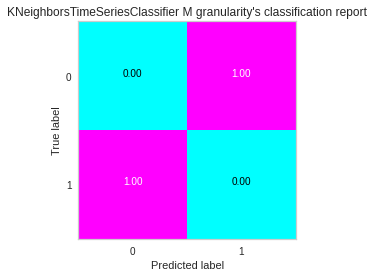

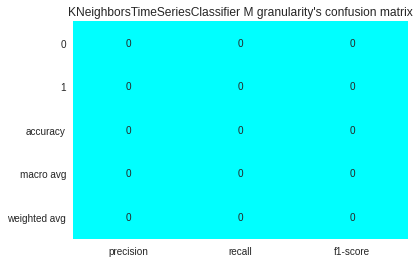

<Figure size 576x360 with 0 Axes>

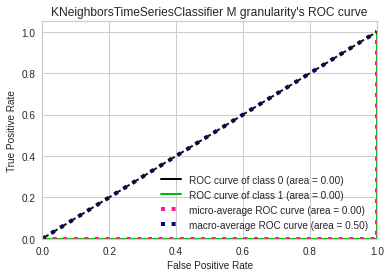

<Figure size 576x360 with 0 Axes>

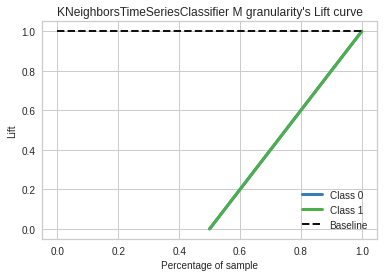


-----------------------------------------------------------------------------------------------------



/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


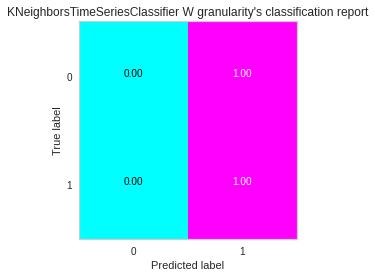

/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


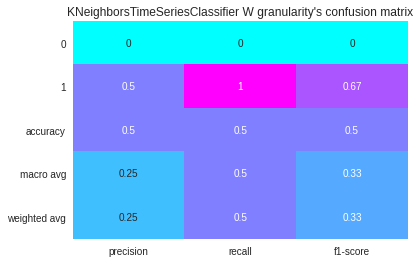

<Figure size 576x360 with 0 Axes>

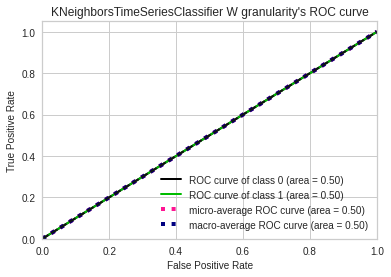

<Figure size 576x360 with 0 Axes>

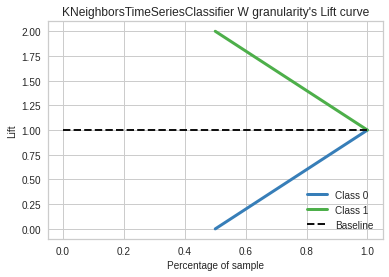


-----------------------------------------------------------------------------------------------------



/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


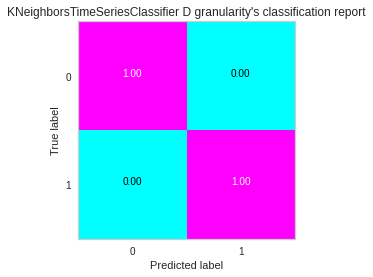

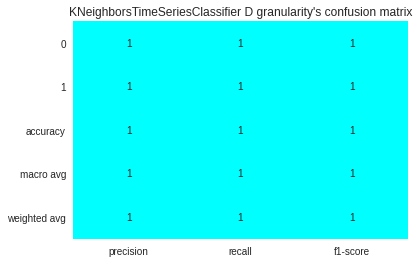

<Figure size 576x360 with 0 Axes>

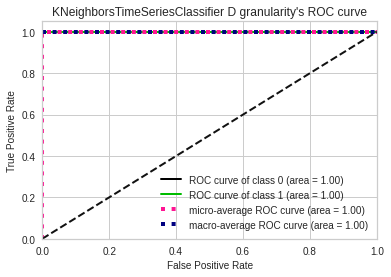

<Figure size 576x360 with 0 Axes>

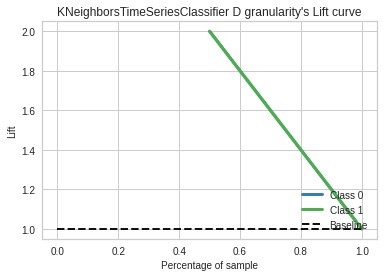


-----------------------------------------------------------------------------------------------------



/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


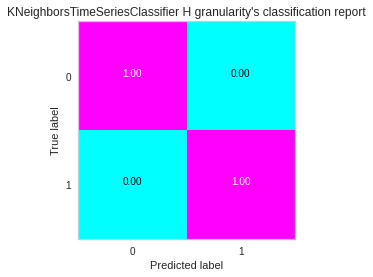

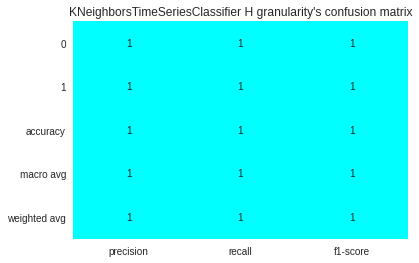

<Figure size 576x360 with 0 Axes>

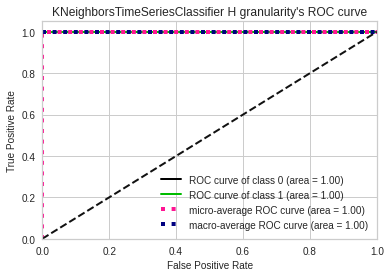

<Figure size 576x360 with 0 Axes>

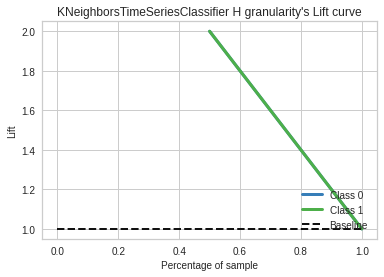


-----------------------------------------------------------------------------------------------------



In [118]:
model_name = "KNeighborsTimeSeriesClassifier"
turn_off_grid_flag = True
for g in granularities:
    if g == 'Y': 
        continue
        
    # define indipendend and dipendent variables
    X, y = clustering_merged_list_of_dataframes[g].values, np.array(([0]*8 + [1]*8))
    
    # NORMALIZATION
    scaler = TimeSeriesScalerMinMax()
    X = scaler.fit_transform(X).reshape(X.shape[0], X.shape[1])
    
    # 70-30 holdout
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
    
    # KNeighborsClassifier
    grid = tslearn_knn_grid(X_train)
    model = KNeighborsTimeSeriesClassifier(n_jobs=-1, verbose=0)
    grid_search(X_train, X_test, y_train, y_test, grid, model, model_name, g, turn_off_grid_flag)
    
    print()
    print("-----------------------------------------------------------------------------------------------------")
    print()

Fitting 3 folds for each of 42 candidates, totalling 126 fits


/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 42 is smaller than n_iter=200. Running 42 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Config: {'model__weights': 'uniform', 'model__n_neighbors': 3, 'model__metric': 'dtw'} 


/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


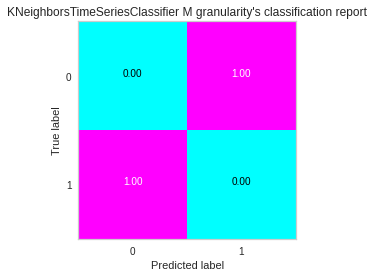

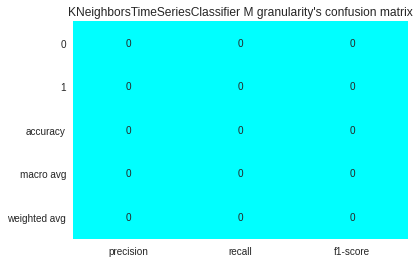

<Figure size 576x360 with 0 Axes>

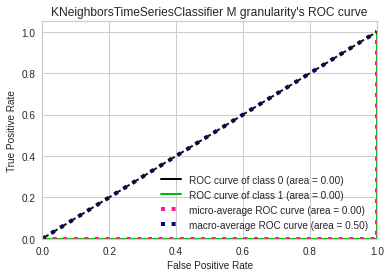

<Figure size 576x360 with 0 Axes>

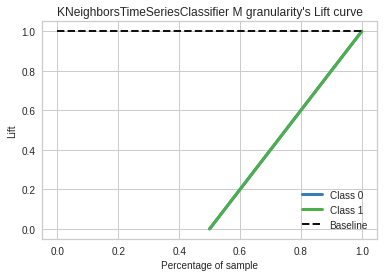


-----------------------------------------------------------------------------------------------------

Fitting 3 folds for each of 42 candidates, totalling 126 fits


/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 42 is smaller than n_iter=200. Running 42 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Config: {'model__weights': 'uniform', 'model__n_neighbors': 5, 'model__metric': 'euclidean'} 


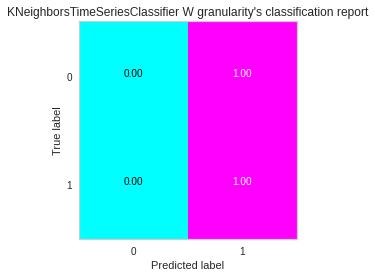

/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


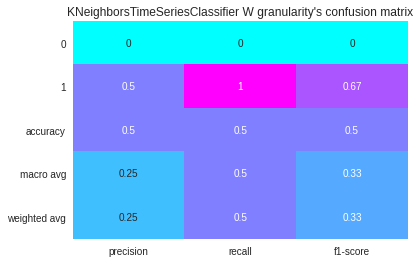

<Figure size 576x360 with 0 Axes>

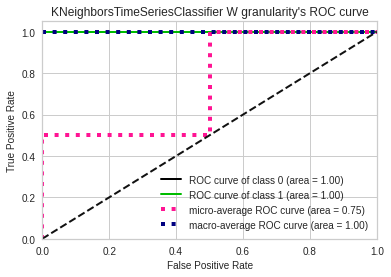

<Figure size 576x360 with 0 Axes>

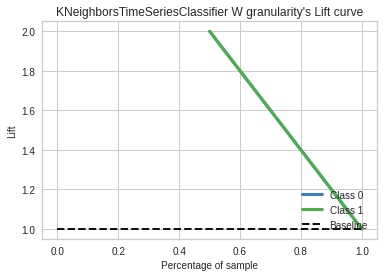


-----------------------------------------------------------------------------------------------------

Fitting 3 folds for each of 42 candidates, totalling 126 fits


/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 42 is smaller than n_iter=200. Running 42 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Config: {'model__weights': 'uniform', 'model__n_neighbors': 3, 'model__metric': 'dtw'} 


/home/alexandra/anaconda3/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 2 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


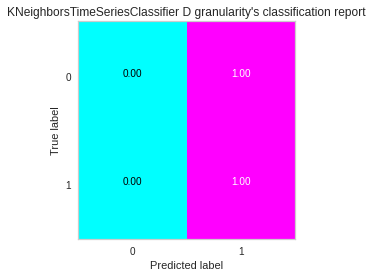

/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


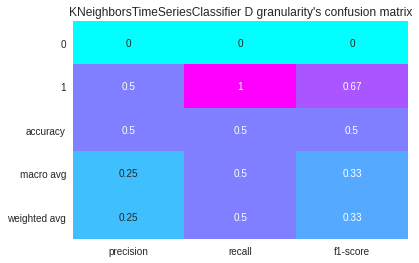

<Figure size 576x360 with 0 Axes>

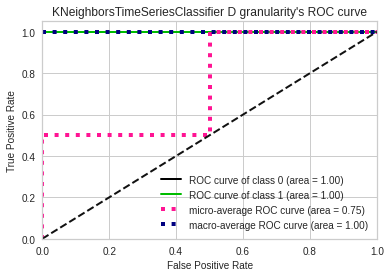

<Figure size 576x360 with 0 Axes>

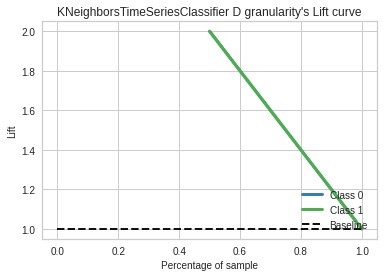


-----------------------------------------------------------------------------------------------------

Fitting 3 folds for each of 42 candidates, totalling 126 fits


/home/alexandra/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 42 is smaller than n_iter=200. Running 42 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [ ]:
model_name = "KNeighborsTimeSeriesClassifier"
turn_off_grid_flag = False
for g in granularities:
    if g == 'Y': 
        continue
        
    # define indipendend and dipendent variables
    X, y = clustering_merged_list_of_dataframes[g].values, np.array(([0]*8 + [1]*8))
    
    # NORMALIZATION
    scaler = TimeSeriesScalerMinMax()
    X = scaler.fit_transform(X).reshape(X.shape[0], X.shape[1])
    
    # 70-30 holdout
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
    
    # KNeighborsClassifier
    grid = tslearn_knn_grid(X_train)
    model = KNeighborsTimeSeriesClassifier(n_jobs=-1, verbose=0)
    grid_search(X_train, X_test, y_train, y_test, grid, model, model_name, g, turn_off_grid_flag)
    
    print()
    print("-----------------------------------------------------------------------------------------------------")
    print()

<h6>Ad-hoc tslearn TimeSeriesSVC</h6>

In [ ]:
from tslearn.svm import TimeSeriesSVC

In [ ]:
def tslearn_svc_grid(X_tr):
    grid = dict()
    grid['model__kernel'] = ['gak', 'linear', 'poly', 'rbf', 'sigmoid']
    grid['model__degree'] = range(2, 11)
    grid['model__gamma'] = ['scale', 'auto']
    grid['model__tol'] = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]
    grid['model__C'] = [0.001, 0.01, 1.0, 10.0, 50.0, 100.0]
    grid['model__class_weight'] = [None, 'balanced']
    return grid

In [ ]:
model_name = "TimeSeriesSVC"
turn_off_grid_flag = True
for g in granularities:
    if g == 'Y': 
        continue
        
    # define indipendend and dipendent variables
    X, y = clustering_merged_list_of_dataframes[g].values, np.array(([0]*8 + [1]*8))
    
    # NORMALIZATION
    scaler = TimeSeriesScalerMinMax()
    X = scaler.fit_transform(X).reshape(X.shape[0], X.shape[1])
    
    # 70-30 holdout
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
    
    # KNeighborsClassifier
    grid = tslearn_svc_grid(X_train)
    model = TimeSeriesSVC(n_jobs=-1, verbose=0, probability=True)
    grid_search(X_train, X_test, y_train, y_test, grid, model, model_name, g, turn_off_grid_flag)
    
    print()
    print("-----------------------------------------------------------------------------------------------------")
    print()

In [ ]:
model_name = "TimeSeriesSVC"
turn_off_grid_flag = False
for g in granularities:
    if g == 'Y': 
        continue
        
    # define indipendend and dipendent variables
    X, y = clustering_merged_list_of_dataframes[g].values, np.array(([0]*8 + [1]*8))
    
    # NORMALIZATION
    scaler = TimeSeriesScalerMinMax()
    X = scaler.fit_transform(X).reshape(X.shape[0], X.shape[1])
    
    # 70-30 holdout
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
    
    # KNeighborsClassifier
    grid = tslearn_svc_grid(X_train)
    model = TimeSeriesSVC(n_jobs=-1, verbose=0, probability=True)
    grid_search(X_train, X_test, y_train, y_test, grid, model, model_name, g, turn_off_grid_flag)
    
    print()
    print("-----------------------------------------------------------------------------------------------------")
    print()